<a href="https://colab.research.google.com/github/sujitojha1/EVA4/blob/rev4/S11/EVA4_S11_Solution_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement EVA 4, Session11 : CIFAR 10

**Target**: 


*   Make sure  to Add CutOut to your code. It should come from your transformations (albumentations)
*   Use this repo: https://github.com/davidtvs/pytorch-lr-finder (Links to an external site.) 
  *  Move LR Finder code to your modules
  *  Implement LR Finder (for SGD, not for ADAM)
  *  Implement ReduceLROnPlatea: https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau (Links to an external site.)
*   Find best LR to train your model
*   Use SDG with Momentum
*   Train for 50 Epochs. 
*   Show Training and Test Accuracy curves
*   Target Accuracy is 88%
*   Run GradCAM on the any 25 misclassified images. Make sure you mention what is the prediction and what was the ground truth label.
*   Submit answers to S10-Assignment-Solution. 

**Results**

*  Total Parameters = 11,173,962
*  After 50 Epochs, Final Train Accuracy = 95.13%
*  After 50 Epochs, Final Test Accuracy = 92.65%

**Analysis**

*  Target accuracy > 88% using Reset18 architecture. Model performance is good as train and test accuracy is small.

## 1. Loading Module and Models 

In [1]:
# Future print function
from __future__ import print_function

# Load modules/models from EVA course
!rm -rf EVA4
!git clone -b rev4 https://github.com/sujitojha1/EVA4 -q --quiet
print("Loaded EVA4 Modules and Models")

# Installing latest Albumentation library
!pip install -U git+https://github.com/albu/albumentations -q --quiet
#pip install apex -q

# For inline matplotlib plotting
%matplotlib inline

Loaded EVA4 Modules and Models
     |████████████████████████████████| 634kB 4.8MB/s 



## 2. Loading train and test data with transforms and loader functions

In [2]:
from EVA4.Modules import *

# Loading test and train data & dataloader
cifar10 = dataset_cifar10(batch_size=512)

# Train dataloader
trainloader = cifar10.loader(train_flag=True)

# Test dataloader
testloader = cifar10.loader(train_flag=False)

classes = cifar10.classes

  pip install torch-lr-finder -v --global-option="amp"


CUDA availability ? True


Extracting ./Data/cifar-10-python.tar.gz to ./Data
Files already downloaded and verified


## 3. Exploratory Data Analysis

### 3.1 Summary Statistics

In [3]:
cifar10.data_summary_stats()
#print(vars(train))

Files already downloaded and verified
Files already downloaded and verified
(60000, 32, 32, 3)
[0.49186878 0.48265391 0.44717728]
[0.24697121 0.24338894 0.26159259]


### 3.2 Plotting sample images

Files already downloaded and verified


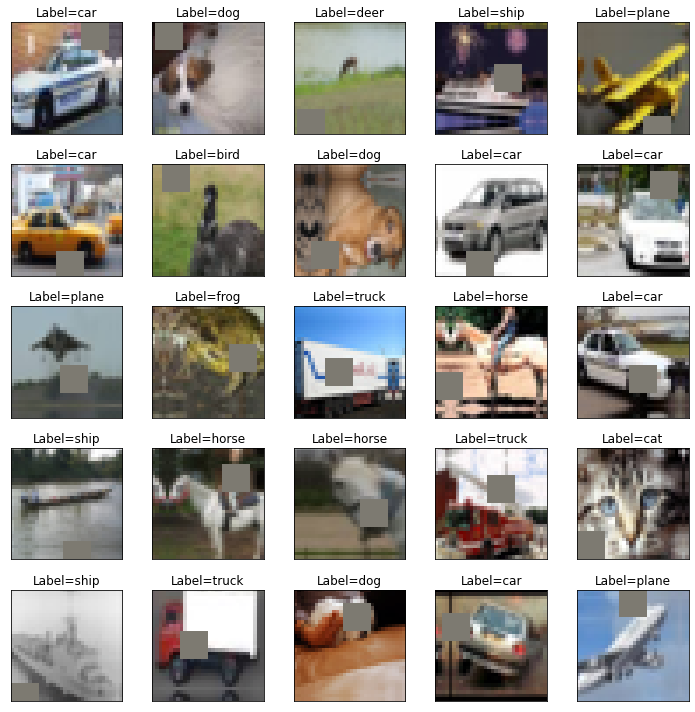

In [4]:
cifar10.sample_pictures(train_flag=True)

# The Model

In [6]:
from EVA4.Models import *

# Loading ResNet18 Model
net = ResNet_Cifar10()

# Using cuda if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

# Sending network to device
net = net.to(device)

cuda


# Model Summary

In [7]:
!pip install torchsummary
from torchsummary import summary

# Model Summary
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
         ResBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         294,912
        MaxPool2d-14            [-1, 25

# Define a Loss function and optimizer

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


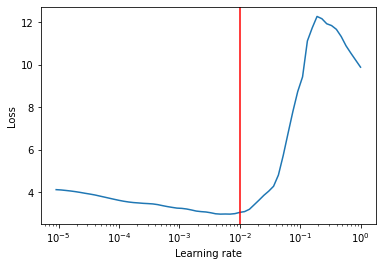

In [8]:
from EVA4.Modules import LRFinder
import torch.optim as optim

model = net
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-6, weight_decay=1e-2,momentum=0.9)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100)
lr_finder.plot(show_lr=0.010) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.10, momentum=0.9, weight_decay=1e-2)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=24)

# Training and Testing

In [10]:
# Load train and test model
from EVA4.Modules import *

train = train()
test = test()

for epoch in range(24):  # loop over the dataset multiple times

    train.execute(net, device, trainloader, optimizer, criterion, epoch)
    test.execute(net, device, testloader, criterion)
    scheduler.step()

print('Finished Training')

  0%|          | 0/98 [00:00<?, ?it/s]


Epoch: 0


Loss=1.4742357730865479 Batch_id=97 Accuracy=36.44: 100%|██████████| 98/98 [00:17<00:00,  5.67it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 5029/10000 (50.29%)


Epoch: 1


Loss=1.1759120225906372 Batch_id=97 Accuracy=53.00: 100%|██████████| 98/98 [00:17<00:00,  5.60it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 5791/10000 (57.91%)


Epoch: 2


Loss=1.1074541807174683 Batch_id=97 Accuracy=58.71: 100%|██████████| 98/98 [00:17<00:00,  5.60it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 6212/10000 (62.12%)


Epoch: 3


Loss=1.1096792221069336 Batch_id=97 Accuracy=62.69: 100%|██████████| 98/98 [00:17<00:00,  5.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 6473/10000 (64.73%)


Epoch: 4


Loss=0.9141251444816589 Batch_id=97 Accuracy=65.25: 100%|██████████| 98/98 [00:17<00:00,  5.66it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 6516/10000 (65.16%)


Epoch: 5


Loss=0.746618390083313 Batch_id=97 Accuracy=68.05: 100%|██████████| 98/98 [00:17<00:00,  5.64it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 7025/10000 (70.25%)


Epoch: 6


Loss=0.8378543853759766 Batch_id=97 Accuracy=69.80: 100%|██████████| 98/98 [00:17<00:00,  5.60it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 7159/10000 (71.59%)


Epoch: 7


Loss=0.9209693670272827 Batch_id=97 Accuracy=70.92: 100%|██████████| 98/98 [00:17<00:00,  5.66it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 7308/10000 (73.08%)


Epoch: 8


Loss=0.7043137550354004 Batch_id=97 Accuracy=73.05: 100%|██████████| 98/98 [00:17<00:00,  5.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7431/10000 (74.31%)


Epoch: 9


Loss=0.6488572359085083 Batch_id=97 Accuracy=74.15: 100%|██████████| 98/98 [00:17<00:00,  5.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7393/10000 (73.93%)


Epoch: 10


Loss=0.6409637928009033 Batch_id=97 Accuracy=75.22: 100%|██████████| 98/98 [00:17<00:00,  5.61it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 7521/10000 (75.21%)


Epoch: 11


Loss=0.7470189332962036 Batch_id=97 Accuracy=76.67: 100%|██████████| 98/98 [00:17<00:00,  5.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7695/10000 (76.95%)


Epoch: 12


Loss=0.6446610689163208 Batch_id=97 Accuracy=77.68: 100%|██████████| 98/98 [00:17<00:00,  5.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7802/10000 (78.02%)


Epoch: 13


Loss=0.5433495044708252 Batch_id=97 Accuracy=78.16: 100%|██████████| 98/98 [00:17<00:00,  5.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7862/10000 (78.62%)


Epoch: 14


Loss=0.5682132244110107 Batch_id=97 Accuracy=79.33: 100%|██████████| 98/98 [00:17<00:00,  5.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7791/10000 (77.91%)


Epoch: 15


Loss=0.5748249888420105 Batch_id=97 Accuracy=79.82: 100%|██████████| 98/98 [00:17<00:00,  5.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7899/10000 (78.99%)


Epoch: 16


Loss=0.6064935326576233 Batch_id=97 Accuracy=80.41: 100%|██████████| 98/98 [00:17<00:00,  5.71it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7938/10000 (79.38%)


Epoch: 17


Loss=0.564943790435791 Batch_id=97 Accuracy=81.20: 100%|██████████| 98/98 [00:17<00:00,  5.68it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 8006/10000 (80.06%)


Epoch: 18


Loss=0.5594725012779236 Batch_id=97 Accuracy=82.05: 100%|██████████| 98/98 [00:17<00:00,  5.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7996/10000 (79.96%)


Epoch: 19


Loss=0.49935010075569153 Batch_id=97 Accuracy=82.48: 100%|██████████| 98/98 [00:17<00:00,  5.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8144/10000 (81.44%)


Epoch: 20


Loss=0.5145246386528015 Batch_id=97 Accuracy=83.08: 100%|██████████| 98/98 [00:17<00:00,  5.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8167/10000 (81.67%)


Epoch: 21


Loss=0.3973526358604431 Batch_id=97 Accuracy=83.86: 100%|██████████| 98/98 [00:17<00:00,  5.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8138/10000 (81.38%)


Epoch: 22


Loss=0.5154740214347839 Batch_id=97 Accuracy=84.18: 100%|██████████| 98/98 [00:17<00:00,  5.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8068/10000 (80.68%)


Epoch: 23


Loss=0.4904288649559021 Batch_id=97 Accuracy=84.47: 100%|██████████| 98/98 [00:17<00:00,  5.62it/s]



Test set: Average loss: 0.0010, Accuracy: 8191/10000 (81.91%)

Finished Training


# Misclassified images


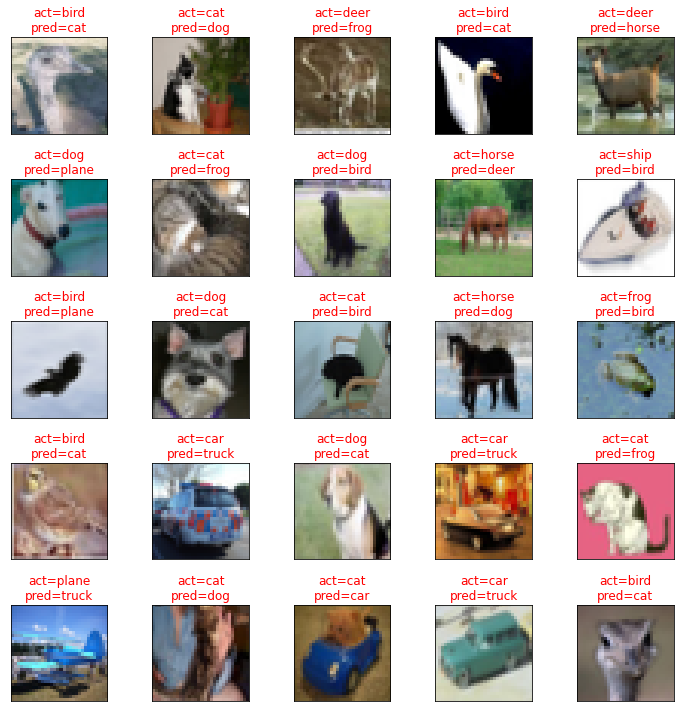

In [11]:
plot_misclassified_images(net,device,testloader,classes)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


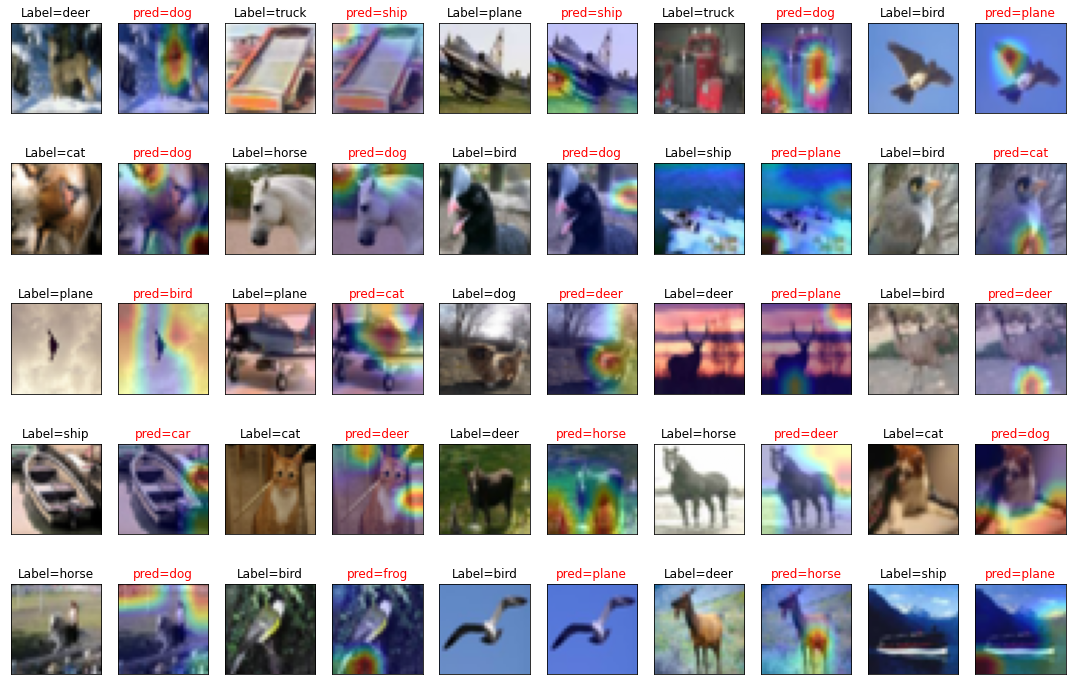

In [12]:
plot_misclassified_images_w_gradcam(net,device,testloader,classes)

# Plotting Train & Test Accuracy/Losses

# Evaluating test Accuracy over different classes 

In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images,labels = images.to(device),labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 90 %
Accuracy of   car : 50 %
Accuracy of  bird : 50 %
Accuracy of   cat : 20 %
Accuracy of  deer : 85 %
Accuracy of   dog : 92 %
Accuracy of  frog : 81 %
Accuracy of horse :  0 %
Accuracy of  ship : 100 %
Accuracy of truck : 71 %


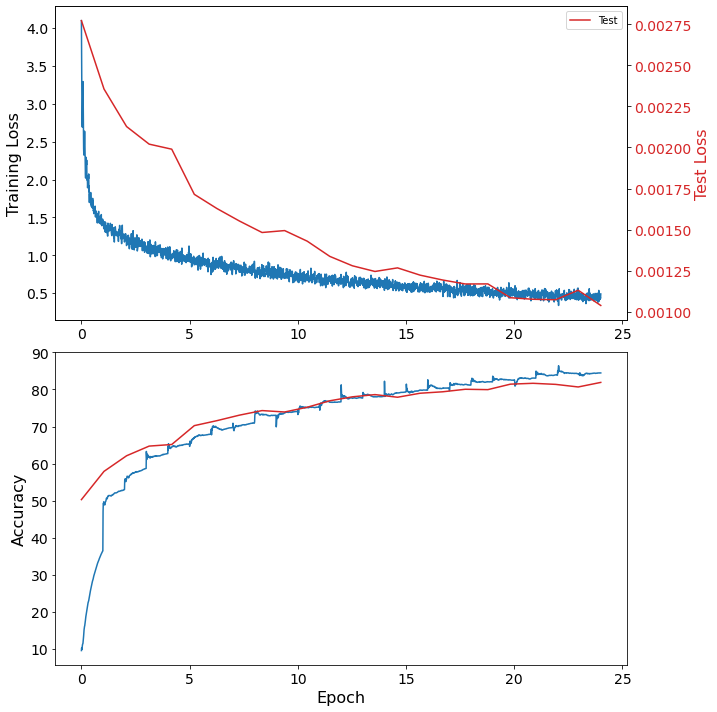

In [14]:
plot_train_test_acc_loss(train,test)